In [1]:
import pandas as pd
import torch
from sentence_transformers import SentenceTransformer
import numpy as np
from sklearn.cluster import KMeans
from sklearn.cluster import DBSCAN
from sklearn.cluster import AgglomerativeClustering
from sklearn.metrics import silhouette_score
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt

/home/luca/Desktop/venv/lib/python3.12/site-packages/sentence_transformers/cross_encoder/CrossEncoder.py:11: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from tqdm.autonotebook import tqdm, trange


In [2]:
df = pd.read_table('resilience_corpus_2019-2024_307.tsv')
documents = list(df['title_text'])

In [3]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

model = SentenceTransformer('thenlper/gte-large').to(device)

def get_embeddings_long_texts(texts, model, chunk_size=512):
    embeddings = []

    for text in texts:
        sentences = text.split('. ')  # Split text into sentences
        chunks = [' '.join(sentences[i:i + chunk_size]) for i in range(0, len(sentences), chunk_size)]
        chunk_embeddings = model.encode(chunks, convert_to_tensor=True, device=device)
        
        # Average embeddings for all chunks
        avg_embedding = torch.mean(chunk_embeddings, dim=0).cpu().numpy()
        embeddings.append(avg_embedding)
    
    return np.vstack(embeddings)

embeddings = get_embeddings_long_texts(documents, model)

In [ ]:
Sum_of_squared_distances = []
K = range(1, 10)
for num_clusters in K :
    kmeans = KMeans(n_clusters=num_clusters, random_state=42)
    kmeans.fit(embeddings)
    Sum_of_squared_distances.append(kmeans.inertia_)
plt.plot(K,Sum_of_squared_distances,'bx-')
plt.xlabel('Values of K') 
plt.ylabel('Sum of squared distances/Inertia') 
plt.title('Elbow Method For Optimal k')
plt.show()

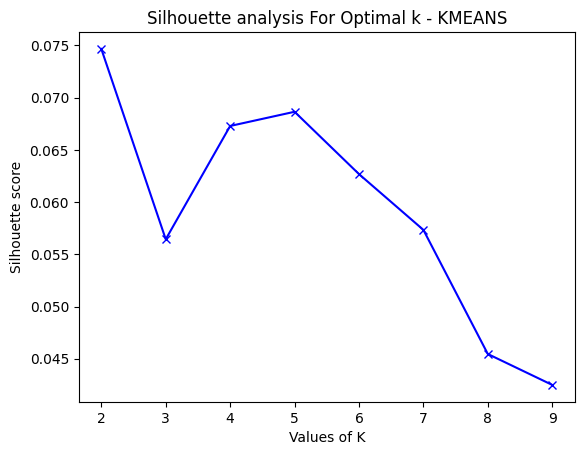

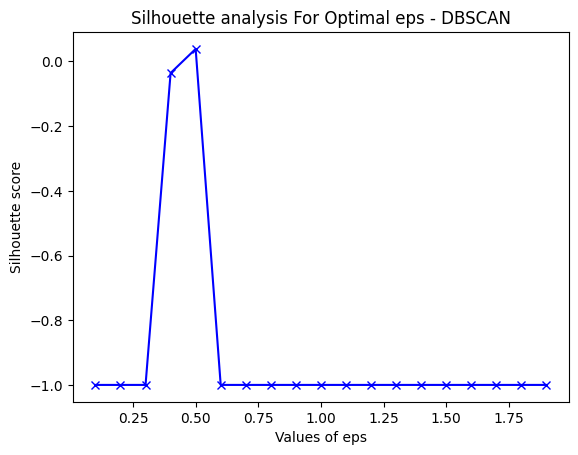

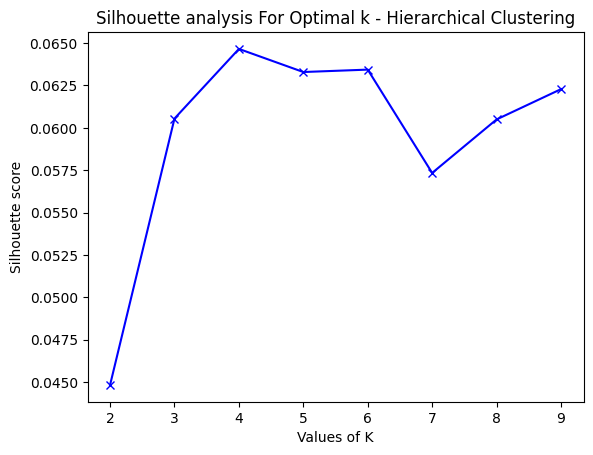

In [5]:
cluster_range = np.arange(2, 10)
silhouette_avg_kmeans = []

for n_clusters in cluster_range:
    kmeans = KMeans(n_clusters=n_clusters, random_state=42)
    kmeans.fit(embeddings)
    labels = kmeans.labels_

    silhouette_avg_kmeans.append(silhouette_score(embeddings, labels))
    
plt.plot(cluster_range, silhouette_avg_kmeans,'bx-')
plt.xlabel('Values of K') 
plt.ylabel('Silhouette score') 
plt.title('Silhouette analysis For Optimal k - KMEANS')
plt.show()

#################################################################################

eps_range = np.arange(0.1, 2.0, 0.1)
silhouette_avg_dbscan = []

for eps in eps_range:
    dbscan = DBSCAN(eps=eps, min_samples=5)  # Adjust min_samples as needed
    labels = dbscan.fit_predict(embeddings)

    # Filter out points classified as noise
    if len(set(labels)) > 1:  # Silhouette score requires at least 2 clusters
        silhouette_avg_dbscan.append(silhouette_score(embeddings, labels))
    else:
        silhouette_avg_dbscan.append(-1)  # Assign a bad score if only one cluster

plt.plot(eps_range, silhouette_avg_dbscan, 'bx-')
plt.xlabel('Values of eps')
plt.ylabel('Silhouette score')
plt.title('Silhouette analysis For Optimal eps - DBSCAN')
plt.show()
##################################################################################

cluster_range = np.arange(2, 10)
silhouette_avg_hierarchical = []

for n_clusters in cluster_range:
    hierarchical = AgglomerativeClustering(n_clusters=n_clusters)
    labels = hierarchical.fit_predict(embeddings)
    silhouette_avg_hierarchical.append(silhouette_score(embeddings, labels))

plt.plot(cluster_range, silhouette_avg_hierarchical, 'bx-')
plt.xlabel('Values of K')
plt.ylabel('Silhouette score')
plt.title('Silhouette analysis For Optimal k - Hierarchical Clustering')
plt.show()